### Import Libraries

In [72]:
import numpy as np
import math as math 
import pandas as pd
import matplotlib as plt
import seaborn as sns
from matplotlib import pyplot as plt
import datetime
import calendar
# from datetime import datetime

from astral.sun import sun
from astral import LocationInfo

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.naive_bayes import GaussianNB

from shapely.geometry.point import Point
import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely import wkt

### Read input files

In [3]:
# df_current_orig = pd.read_csv ('NYPD_Complaint_Data_Current__Year_To_Date.csv')
df_current_orig = pd.read_csv('/Volumes/CUNYGC/GC/CIS74020_ML/Final Project/Data/NYPD_Complaint_Data_Current__Year_To_Date.csv', sep=",")
df_current = df_current_orig

# df_hist_orig = pd.read_csv ('NYPD_Complaint_Data_Historic.csv')
df_hist_orig = pd.read_csv('/Volumes/CUNYGC/GC/CIS74020_ML/Final Project/Data/NYPD_Complaint_Data_Historic.csv', sep=",")
df_hist = df_hist_orig


/Users/denisgostev/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (18,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


#### Select required columns and drop not colmepleted (attempted) crimes

In [4]:
df_current = df_current[['ADDR_PCT_CD','CMPLNT_FR_DT','CMPLNT_FR_TM', 
                        'LAW_CAT_CD','OFNS_DESC','LOC_OF_OCCUR_DESC', 
                        'JURIS_DESC','Latitude','Longitude']] \
                        [df_current['CRM_ATPT_CPTD_CD'] == 'COMPLETED']

df_hist = df_hist     [['ADDR_PCT_CD','CMPLNT_FR_DT','CMPLNT_FR_TM', 
                        'LAW_CAT_CD','OFNS_DESC','LOC_OF_OCCUR_DESC', 
                        'JURIS_DESC','Latitude','Longitude']] \
                        [df_hist['CRM_ATPT_CPTD_CD'] == 'COMPLETED']

#### Reformat and clean up dates

In [5]:
#Reformat from mm/dd/yyyy to yyyy-mm-dd
df_current['CMPLNT_FR_DT'] = pd.to_datetime(df_current['CMPLNT_FR_DT'], format='%m/%d/%Y', errors = 'coerce')
df_hist['CMPLNT_FR_DT'] = pd.to_datetime(df_hist['CMPLNT_FR_DT'], format='%m/%d/%Y', errors = 'coerce')

print( 'Number of rows in current where date is null:', df_current[df_current['CMPLNT_FR_DT'].isna()].shape[0])
print( 'Number of rows in hist where date is null:', df_hist[df_hist['CMPLNT_FR_DT'].isna()].shape[0])
df_current=df_current[df_current['CMPLNT_FR_DT'].notna()]  #Get rid of nulls
df_hist=df_hist[df_hist['CMPLNT_FR_DT'].notna()]  #Get rid of nulls
print( 'Number of rows in current where date is null after clean up:', df_current[df_current['CMPLNT_FR_DT'].isna()].shape[0])
print( 'Number of rows in hist where date is null after clean up:', df_hist[df_hist['CMPLNT_FR_DT'].isna()].shape[0])


print('\nNumber of rows in current with date earlier than 2020: ',  df_current[df_current['CMPLNT_FR_DT'] < '01/01/2020'].shape[0])
print('Number of rows in hist with date earlier than 2006: ',  df_hist[df_hist['CMPLNT_FR_DT'] < '01/01/2006'].shape[0])
df_current = df_current[df_current['CMPLNT_FR_DT'] >= '01/01/2020']   #get rid of rows with dates earlier than 2020
df_hist = df_hist[df_hist['CMPLNT_FR_DT'] >= '01/01/2006']   #get rid of rows with dates earlier than 2006
print('Number of rows in current with date earlier than 2020 after clean up: ',  df_current[df_current['CMPLNT_FR_DT'] < '01/01/2020'].shape[0])
print('Number of rows in hist with date earlier than 2006 after clean up: ',  df_hist[df_hist['CMPLNT_FR_DT'] < '01/01/2006'].shape[0])


Number of rows in current where date is null: 9
Number of rows in hist where date is null: 797
Number of rows in current where date is null after clean up: 0
Number of rows in hist where date is null after clean up: 0

Number of rows in current with date earlier than 2020:  8414
Number of rows in hist with date earlier than 2006:  19651
Number of rows in current with date earlier than 2020 after clean up:  0
Number of rows in hist with date earlier than 2006 after clean up:  0


#### Put 2 dataframes togather and clean up null coord

In [8]:
df_all = df_hist.append(df_current)

print('Before Clean up')
print(df_all.isnull().sum())

df_all=df_all[df_all['CMPLNT_FR_TM'].notna()]
df_all=df_all[df_all['Latitude'].notna()]
df_all=df_all[df_all['Longitude'].notna()]

print('\nAfter Clean up')
print(df_all.isnull().sum())

Before Clean up
ADDR_PCT_CD             2061
CMPLNT_FR_DT               0
CMPLNT_FR_TM              46
LAW_CAT_CD                 0
OFNS_DESC              18593
LOC_OF_OCCUR_DESC    1517534
JURIS_DESC                 0
Latitude               23150
Longitude              23150
dtype: int64

After Clean up
ADDR_PCT_CD             1293
CMPLNT_FR_DT               0
CMPLNT_FR_TM               0
LAW_CAT_CD                 0
OFNS_DESC              18475
LOC_OF_OCCUR_DESC    1513220
JURIS_DESC                 0
Latitude                   0
Longitude                  0
dtype: int64


#### Remove inccorrect prieienct

In [10]:
print('# of records in each precinct ', df_all['ADDR_PCT_CD'].value_counts())

#Remove prieienct # -99
df_all=df_all[df_all['ADDR_PCT_CD'] > 0]

# of records in each precinct   75.0     231936
 43.0     186062
 44.0     180711
 40.0     175145
 14.0     163959
           ...  
 111.0     44684
 76.0      40222
 100.0     38451
 22.0       5567
-99.0        746
Name: ADDR_PCT_CD, Length: 78, dtype: int64


#### Retrieve time of sunrise and sunset for all dates 

In [11]:
date_range = pd.date_range(start='1/1/2006', end='1/1/2021', freq='D')
date_range = pd.DatetimeIndex.to_frame(date_range).reset_index()

sunrise_list = list()
sunset_list = list()

for i in range(len(date_range)):
    
    cmp_year = date_range['index'][i].year
    cmp_mnth = date_range['index'][i].month
    cmp_day = date_range['index'][i].day 
    
    loc = LocationInfo(name='New York', region='NY, USA', timezone='US/Eastern', latitude=40.71666666666667, longitude= -74.0)  
    s = sun(loc.observer, date=datetime.date(cmp_year, cmp_mnth, cmp_day), tzinfo=loc.timezone)
    
    sun_rise_time = s['sunrise'].strftime("%X")
    sun_set_time  = s['sunset'].strftime("%X")
    
    sunrise_list.append(sun_rise_time)
    sunset_list.append(sun_set_time)

date_range['sunrise']  = sunrise_list
date_range['sunset']  = sunset_list

df_all = pd.merge(df_all, date_range,
         left_on="CMPLNT_FR_DT",
         right_on="index")

#### Construct Features (TIME_CAT, DAY_OF_WEEK....)

In [12]:
#Execution time is VERY long
#==========================

def InOut (x):
    if x != 'INSIDE':
        in_out_desc = 'OUTSIDE'
    else:
        in_out_desc = 'INSIDE'
    return (in_out_desc)

def timeHour (x):
    return (x[:2])

def day_night (row):   
    time = row['CMPLNT_FR_TM'] 
    
    sun_rise_time = row['sunrise'] 
    sun_set_time = row['sunset'] 
        
    if time < '04:00:00':
        return ('NIGHT')
    elif time < sun_rise_time:
        return ('MORNING BEFORE SUNRISE')
    elif time < '12:00:00':
        return ('MORNING AFTER SUNRISE')
    elif time < '16:00:00':
        return ('AFTERNOON')
    elif time < sun_set_time:
        return ('EVENING BEFORE SUNSET')
    elif time < '21:00:00':
        return ('EVENING AFTER SUNSET')
    else:
        return ('NIGHT')

df_all['TIME_CAT'] = df_all.apply(day_night, axis=1)
# df2['TIME_CAT'] = df2['CMPLNT_FR_TM'].apply(timeCat)

df_all['INSIDE'] = df_all['LOC_OF_OCCUR_DESC'].apply(InOut)
df_all['TIME'] = df_all['CMPLNT_FR_TM'].apply(timeHour)

df_all['WEEK'] = df_all['CMPLNT_FR_DT'].dt.week
df_all['DAY'] = df_all['CMPLNT_FR_DT'].dt.day
df_all['DAY_OF_WEEK'] = df_all['CMPLNT_FR_DT'].dt.dayofweek
df_all['YEAR'] = df_all['CMPLNT_FR_DT'].dt.year

<ipython-input-12-5789b811881a>:38: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_all['WEEK'] = df_all['CMPLNT_FR_DT'].dt.week


#### Plot 3 LAW_CAT_CD by Year

<AxesSubplot:xlabel='YEAR', ylabel=' Count'>

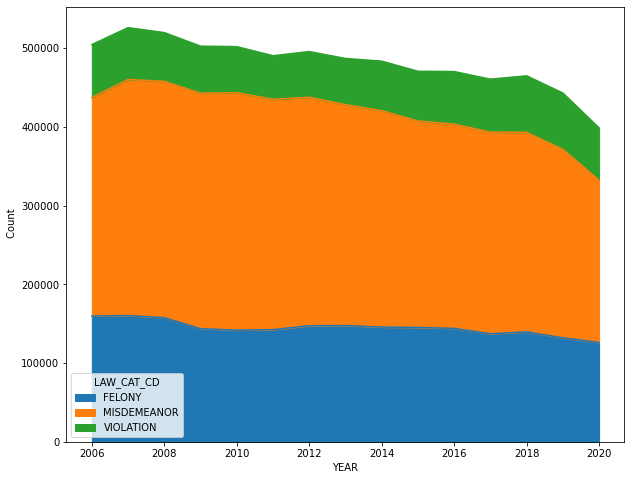

In [13]:
df_all.columns

a=df_all.head(20)

df_all_cat_year = df_all.groupby(['LAW_CAT_CD', 'YEAR']).size().reset_index(name='counts') #per day
df_all_cat_year_pivot = df_all_cat_year.pivot(index='YEAR', columns='LAW_CAT_CD', values='counts').reset_index()

 
df_all_cat_year_pivot.plot(kind='area',x='YEAR',figsize=[10,8], xlabel = 'YEAR', ylabel = ' Count')

#### Plot top 10 OFNS_DESC by Year

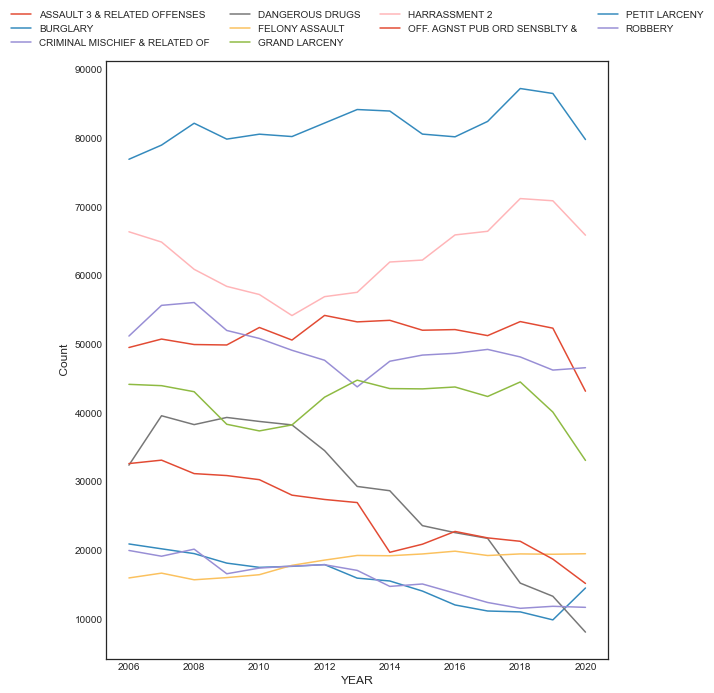

In [84]:
df_all_cat_year_ofs = df_all.groupby(['OFNS_DESC']).size().reset_index(name='counts') #per day

#Selet top 10 OFNS_DESC
top_ofs = df_all.groupby(['OFNS_DESC']).size().sort_values(ascending=False).head(10).reset_index()['OFNS_DESC']
top_ofs_list = list(top_ofs)
df_all_top_ofs = df_all[df_all['OFNS_DESC'].isin(top_ofs_list) ]


df_all_top_ofs = df_all_top_ofs.groupby(['OFNS_DESC', 'YEAR']).size().reset_index(name='counts') #per day
df_all_top_ofs_pivot = df_all_top_ofs.pivot(index='YEAR', columns='OFNS_DESC', values='counts').reset_index()

df_all_top_ofs_pivot.plot(x='YEAR',figsize=[9,11], xlabel = 'YEAR', ylabel = ' Count') 
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4, fontsize=10)

#### Plot 3 LAW_CAT_CD by DAY_OF_WEEK 

([<matplotlib.axis.XTick at 0x174f23070>,
 [Text(0, 0, 'Monday'),
  Text(1, 0, 'Tuesday'),
  Text(2, 0, 'Wednesday'),
  Text(3, 0, 'Thrursday'),
  Text(4, 0, 'Friday'),
  Text(5, 0, 'Saturday'),
  Text(6, 0, 'Sunday')])

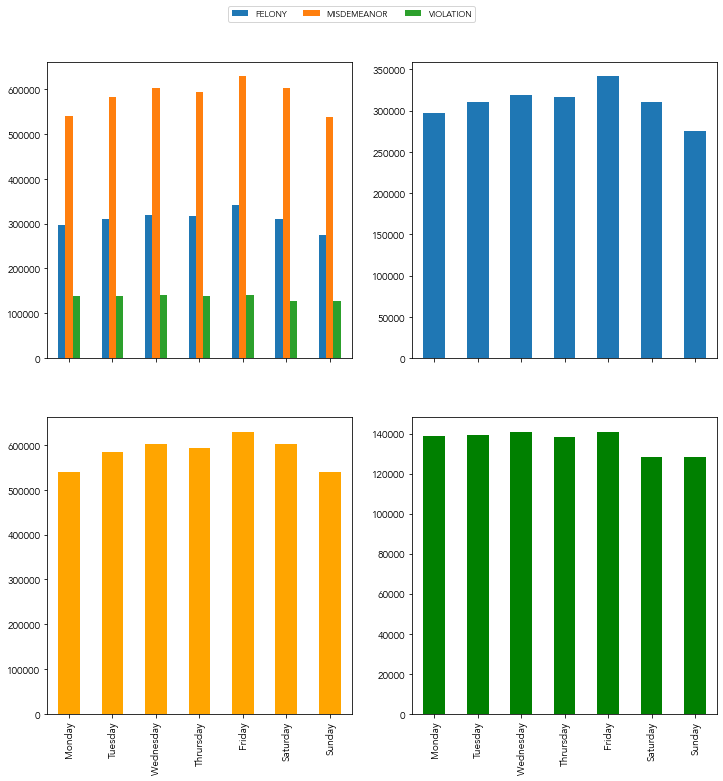

In [20]:
df_all_day = df_all.groupby(['LAW_CAT_CD','DAY_OF_WEEK']).size().reset_index(name='counts') #per day
df_all_day_pivot = df_all_day.pivot(index='DAY_OF_WEEK', columns='LAW_CAT_CD', values='counts').reset_index()

df_all_day_pivot['DAY_OF_WEEK'] = df_all_day_pivot['DAY_OF_WEEK'].apply(lambda x: calendar.day_name[x] )

# df_all_day_pivot.plot(kind='bar', x='DAY_OF_WEEK', stacked=False)

plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['font.family'] = "Avenir"
fig, ax = plt.subplots(2, 2, sharex=True)  #sharex="all", sharey="all"
ax[0,0] = df_all_day_pivot.plot(kind='bar',x='DAY_OF_WEEK', ax=ax[0,0]) #x='DAY_OF_WEEK'
ax[0,0].get_legend().remove()
ax[0,1] = df_all_day_pivot['FELONY'].plot(kind='bar', x='DAY_OF_WEEK', ax=ax[0,1])
ax[1,0] = df_all_day_pivot['MISDEMEANOR'].plot(kind='bar', x='DAY_OF_WEEK', ax=ax[1,0], color = 'orange')
ax[1,1] = df_all_day_pivot['VIOLATION'].plot(kind='bar', x='DAY_OF_WEEK', ax=ax[1,1], color = 'green')
ax[0,0].legend(loc='upper center', bbox_to_anchor=(1, 1.2), ncol=3, fontsize='small')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ["Monday", "Tuesday", "Wednesday", "Thrursday", "Friday", "Saturday", "Sunday"])

####  Plot top 16 OFNS_DESC by Day of Week

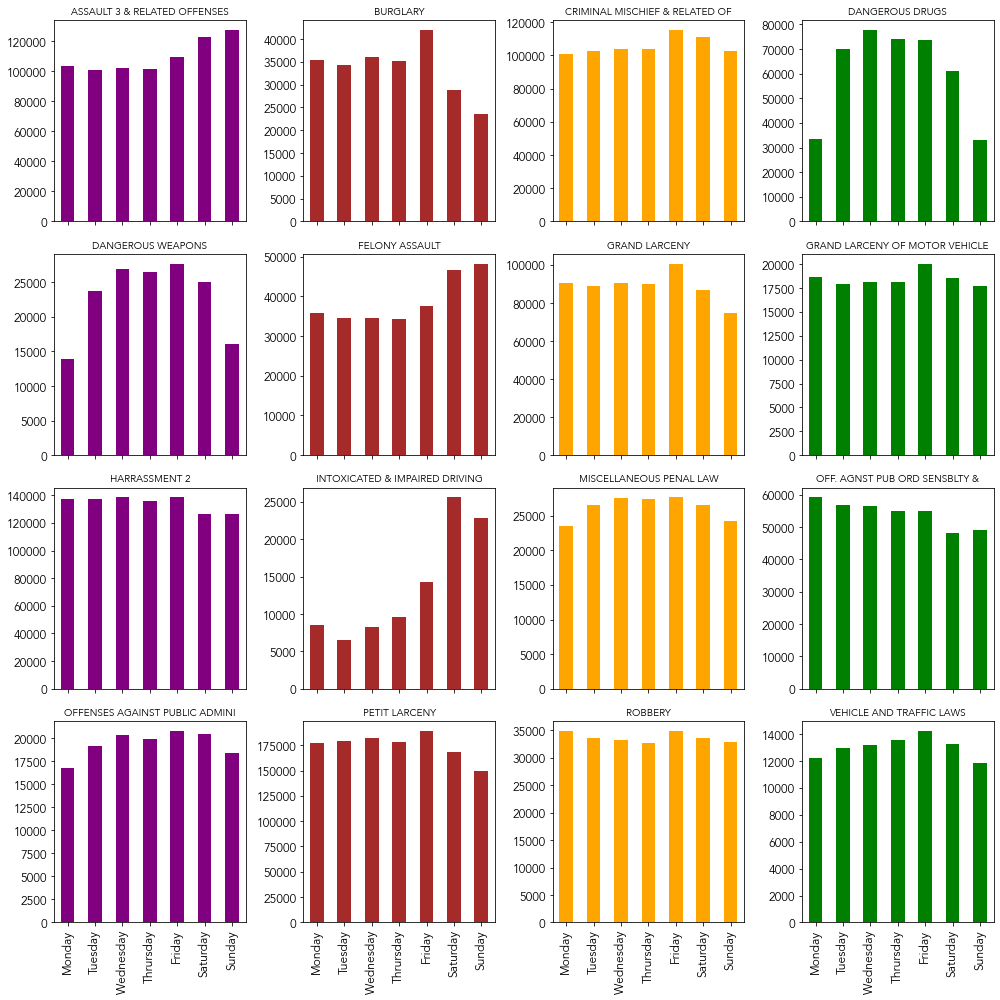

In [43]:
top_ofs = df_all.groupby(['OFNS_DESC']).size().sort_values(ascending=False).head(16).reset_index()['OFNS_DESC']
top_ofs_list = list(top_ofs)
df_all_top_ofs = df_all[df_all['OFNS_DESC'].isin(top_ofs_list) ]


df_all_day = df_all_top_ofs.groupby(['OFNS_DESC','DAY_OF_WEEK']).size().reset_index(name='counts') #per day
df_all_day_pivot = df_all_day.pivot(index='DAY_OF_WEEK', columns='OFNS_DESC', values='counts').reset_index()

df_all_day_pivot['DAY_OF_WEEK'] = df_all_day_pivot['DAY_OF_WEEK'].apply(lambda x: calendar.day_name[x] )

# df_all_day_pivot.plot(kind='bar', x='DAY_OF_WEEK', stacked=False)

plt.rcParams['figure.figsize'] = (14, 14)
plt.rcParams['font.family'] = "Avenir"
fig, ax = plt.subplots(4, 4, sharex=True)  #sharex="all", sharey="all"  
# plt.set_title(size=10) # Title 

ax[0,0] = df_all_day_pivot.iloc[:,1].plot(kind='bar', ax=ax[0,0],color = 'purple', fontsize=12), ax[0,0].set_title (df_all_day_pivot.columns[1], fontsize=10)
ax[0,1] = df_all_day_pivot.iloc[:,2].plot(kind='bar', ax=ax[0,1], color = 'brown', fontsize=12),  ax[0,1].set_title (df_all_day_pivot.columns[2], fontsize=10)
ax[0,2] = df_all_day_pivot.iloc[:,3].plot(kind='bar', ax=ax[0,2], color = 'orange', fontsize=12), ax[0,2].set_title (df_all_day_pivot.columns[3], fontsize=10)
ax[0,3] = df_all_day_pivot.iloc[:,4].plot(kind='bar', ax=ax[0,3], color = 'green', fontsize=12), ax[0,3].set_title (df_all_day_pivot.columns[4], fontsize=10)
ax[1,0] = df_all_day_pivot.iloc[:,5].plot(kind='bar', ax=ax[1,0],color = 'purple', fontsize=12),ax[1,0].set_title (df_all_day_pivot.columns[5], fontsize=10) 
ax[1,1] = df_all_day_pivot.iloc[:,6].plot(kind='bar', ax=ax[1,1], color = 'brown',  fontsize=12),ax[1,1].set_title (df_all_day_pivot.columns[6], fontsize=10) 
ax[1,2] = df_all_day_pivot.iloc[:,7].plot(kind='bar', ax=ax[1,2], color = 'orange',fontsize=12),ax[1,2].set_title (df_all_day_pivot.columns[7], fontsize=10) 
ax[1,3] = df_all_day_pivot.iloc[:,8].plot(kind='bar', ax=ax[1,3], color = 'green', fontsize=12),ax[1,3].set_title (df_all_day_pivot.columns[8], fontsize=10) 
ax[2,0] = df_all_day_pivot.iloc[:,9].plot(kind='bar', ax=ax[2,0],color = 'purple', fontsize=12),ax[2,0].set_title (df_all_day_pivot.columns[9], fontsize=10) 
ax[2,1] = df_all_day_pivot.iloc[:,10].plot(kind='bar', ax=ax[2,1], color = 'brown', fontsize=12),ax[2,1].set_title (df_all_day_pivot.columns[10], fontsize=10) 
ax[2,2] = df_all_day_pivot.iloc[:,11].plot(kind='bar', ax=ax[2,2], color = 'orange',fontsize=12),ax[2,2].set_title (df_all_day_pivot.columns[11], fontsize=10) 
ax[2,3] = df_all_day_pivot.iloc[:,12].plot(kind='bar', ax=ax[2,3], color = 'green', fontsize=12),ax[2,3].set_title (df_all_day_pivot.columns[12], fontsize=10) 
ax[3,0] = df_all_day_pivot.iloc[:,13].plot(kind='bar', ax=ax[3,0],color = 'purple', fontsize=12),ax[3,0].set_title (df_all_day_pivot.columns[13], fontsize=10)  
ax[3,1] = df_all_day_pivot.iloc[:,14].plot(kind='bar', ax=ax[3,1], color = 'brown', fontsize=12),ax[3,1].set_title (df_all_day_pivot.columns[14], fontsize=10) 
ax[3,2] = df_all_day_pivot.iloc[:,15].plot(kind='bar', ax=ax[3,2], color = 'orange',fontsize=12),ax[3,2].set_title (df_all_day_pivot.columns[15], fontsize=10) 
ax[3,3] = df_all_day_pivot.iloc[:,16].plot(kind='bar', ax=ax[3,3], color = 'green', fontsize=12),ax[3,3].set_title (df_all_day_pivot.columns[16], fontsize=10) 

plt.xticks([0, 1, 2, 3, 4, 5, 6], ["Monday", "Tuesday", "Wednesday", "Thrursday", "Friday", "Saturday", "Sunday"])
plt.tight_layout()

#### Plot 3 LAW_CAT_CD by Time of Day

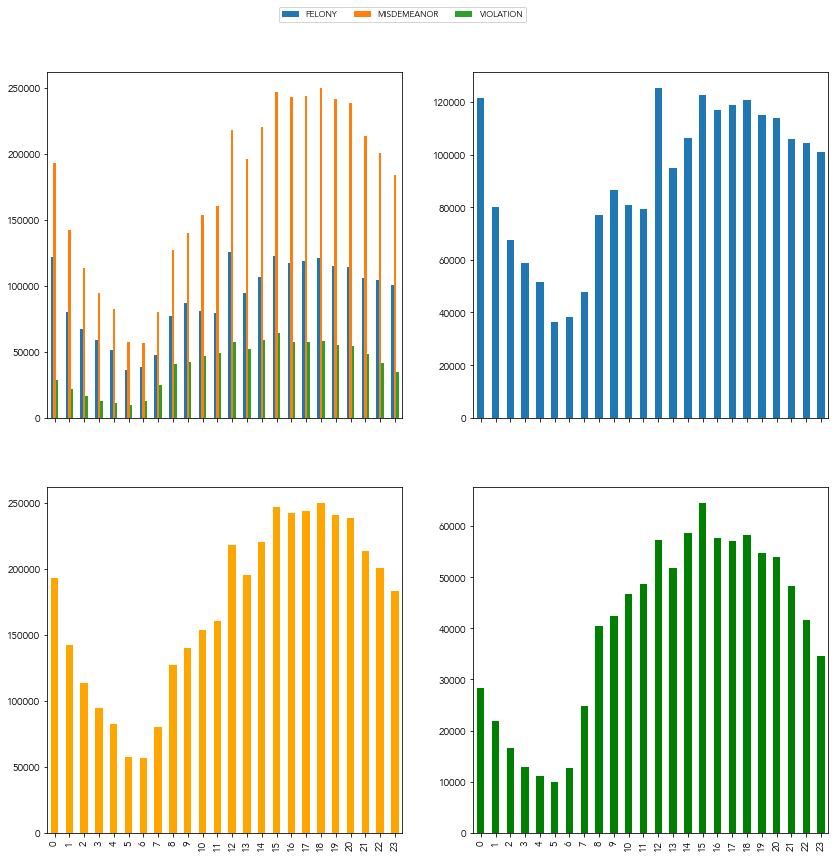

In [28]:
df_all_day = df_all.groupby(['LAW_CAT_CD','TIME']).size().reset_index(name='counts') #per day
df_all_day_pivot = df_all_day.pivot(index='TIME', columns='LAW_CAT_CD', values='counts').reset_index()

# df_all_day_pivot.plot(kind='bar', x='DAY_OF_WEEK', stacked=False)

plt.rcParams['figure.figsize'] = (14, 14)
plt.rcParams['font.family'] = "Avenir"
fig, ax = plt.subplots(2, 2, sharex=True)  #sharex="all", sharey="all"
ax[0,0] = df_all_day_pivot.plot(kind='bar',x='TIME', ax=ax[0,0]) #x='DAY_OF_WEEK'
ax[0,0].get_legend().remove()
ax[0,1] = df_all_day_pivot['FELONY'].plot(kind='bar', x='TIME', ax=ax[0,1])
ax[1,0] = df_all_day_pivot['MISDEMEANOR'].plot(kind='bar', x='TIME', ax=ax[1,0], color = 'orange')
ax[1,1] = df_all_day_pivot['VIOLATION'].plot(kind='bar', x='TIME', ax=ax[1,1], color = 'green')
ax[0,0].legend(loc='upper center', bbox_to_anchor=(1, 1.2), ncol=3, fontsize='small')

#### Plot top 16 OFNS_DESC by Time of Day

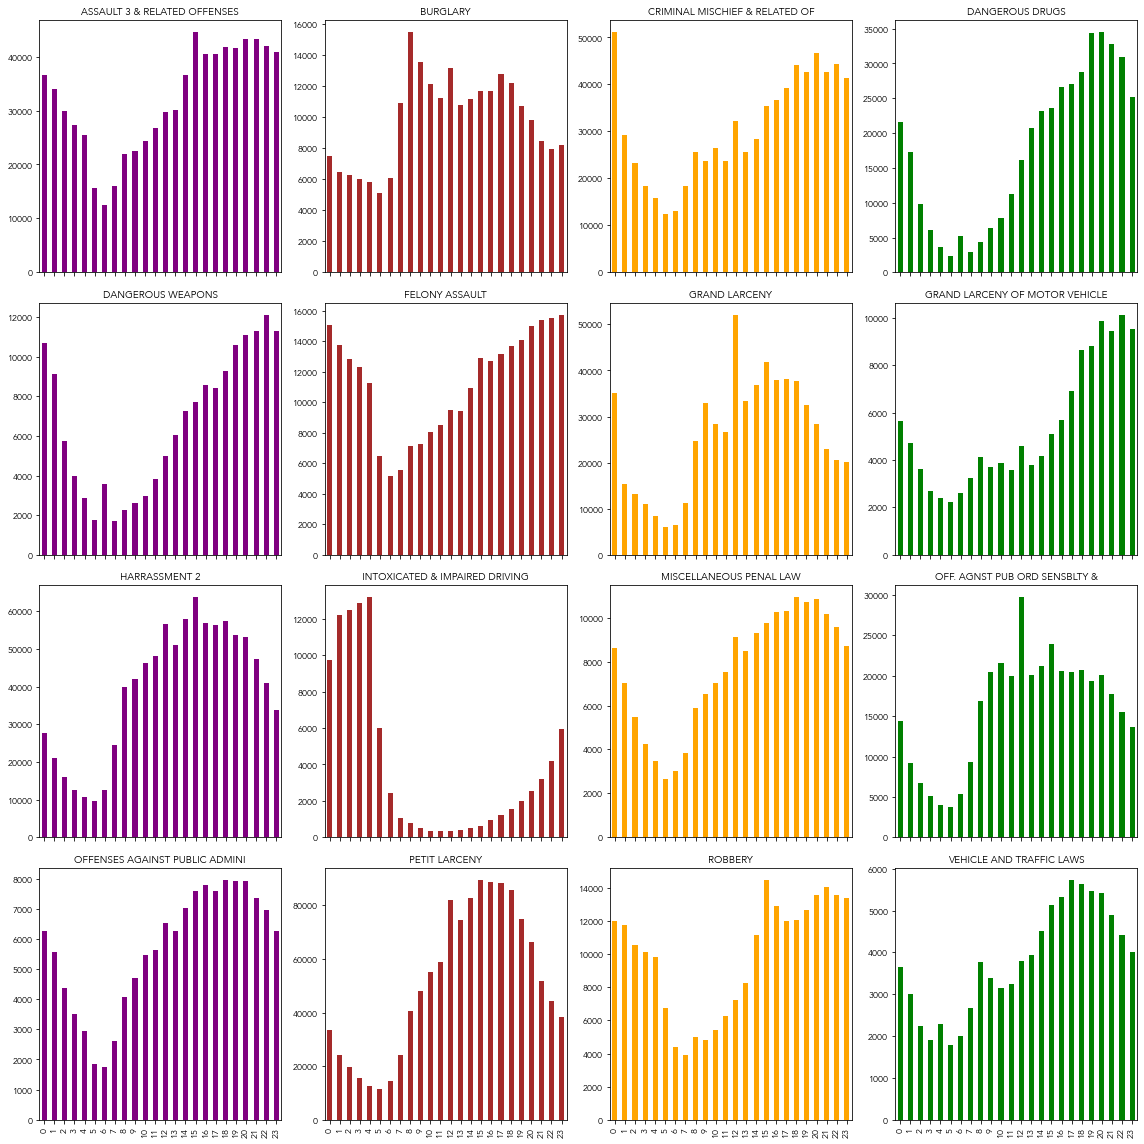

In [47]:
top_ofs = df_all.groupby(['OFNS_DESC']).size().sort_values(ascending=False).head(16).reset_index()['OFNS_DESC']
top_ofs_list = list(top_ofs)
df_all_top_ofs = df_all[df_all['OFNS_DESC'].isin(top_ofs_list) ]


df_all_day = df_all_top_ofs.groupby(['OFNS_DESC','TIME']).size().reset_index(name='counts') #per day
df_all_day_pivot = df_all_day.pivot(index='TIME', columns='OFNS_DESC', values='counts').reset_index()

plt.rcParams['figure.figsize'] = (16, 16)
plt.rcParams['font.family'] = "Avenir"
fig, ax = plt.subplots(4, 4, sharex=True)  #sharex="all", sharey="all"  

ax[0,0] = df_all_day_pivot.iloc[:,1].plot(kind='bar', ax=ax[0,0],color = 'purple', fontsize=9), ax[0,0].set_title (df_all_day_pivot.columns[1], fontsize=10)
ax[0,1] = df_all_day_pivot.iloc[:,2].plot(kind='bar', ax=ax[0,1], color = 'brown', fontsize=9),  ax[0,1].set_title (df_all_day_pivot.columns[2], fontsize=10)
ax[0,2] = df_all_day_pivot.iloc[:,3].plot(kind='bar', ax=ax[0,2], color = 'orange', fontsize=9), ax[0,2].set_title (df_all_day_pivot.columns[3], fontsize=10)
ax[0,3] = df_all_day_pivot.iloc[:,4].plot(kind='bar', ax=ax[0,3], color = 'green', fontsize=9), ax[0,3].set_title (df_all_day_pivot.columns[4], fontsize=10)
ax[1,0] = df_all_day_pivot.iloc[:,5].plot(kind='bar', ax=ax[1,0],color = 'purple', fontsize=9),ax[1,0].set_title (df_all_day_pivot.columns[5], fontsize=10) 
ax[1,1] = df_all_day_pivot.iloc[:,6].plot(kind='bar', ax=ax[1,1], color = 'brown',  fontsize=9),ax[1,1].set_title (df_all_day_pivot.columns[6], fontsize=10) 
ax[1,2] = df_all_day_pivot.iloc[:,7].plot(kind='bar', ax=ax[1,2], color = 'orange',fontsize=9),ax[1,2].set_title (df_all_day_pivot.columns[7], fontsize=10) 
ax[1,3] = df_all_day_pivot.iloc[:,8].plot(kind='bar', ax=ax[1,3], color = 'green', fontsize=9),ax[1,3].set_title (df_all_day_pivot.columns[8], fontsize=10) 
ax[2,0] = df_all_day_pivot.iloc[:,9].plot(kind='bar', ax=ax[2,0],color = 'purple', fontsize=9),ax[2,0].set_title (df_all_day_pivot.columns[9], fontsize=10) 
ax[2,1] = df_all_day_pivot.iloc[:,10].plot(kind='bar', ax=ax[2,1], color = 'brown', fontsize=9),ax[2,1].set_title (df_all_day_pivot.columns[10], fontsize=10) 
ax[2,2] = df_all_day_pivot.iloc[:,11].plot(kind='bar', ax=ax[2,2], color = 'orange',fontsize=9),ax[2,2].set_title (df_all_day_pivot.columns[11], fontsize=10) 
ax[2,3] = df_all_day_pivot.iloc[:,12].plot(kind='bar', ax=ax[2,3], color = 'green', fontsize=9),ax[2,3].set_title (df_all_day_pivot.columns[12], fontsize=10) 
ax[3,0] = df_all_day_pivot.iloc[:,13].plot(kind='bar', ax=ax[3,0],color = 'purple', fontsize=9),ax[3,0].set_title (df_all_day_pivot.columns[13], fontsize=10)  
ax[3,1] = df_all_day_pivot.iloc[:,14].plot(kind='bar', ax=ax[3,1], color = 'brown', fontsize=9),ax[3,1].set_title (df_all_day_pivot.columns[14], fontsize=10) 
ax[3,2] = df_all_day_pivot.iloc[:,15].plot(kind='bar', ax=ax[3,2], color = 'orange',fontsize=9),ax[3,2].set_title (df_all_day_pivot.columns[15], fontsize=10) 
ax[3,3] = df_all_day_pivot.iloc[:,16].plot(kind='bar', ax=ax[3,3], color = 'green', fontsize=9),ax[3,3].set_title (df_all_day_pivot.columns[16], fontsize=10) 

plt.tight_layout()

# Build Classification Algorithms

### Build KNN

#### Prepare dataset

In [48]:
# Year 2020
df_2019 = df_all[df_all['YEAR'] <= 2019]

#Select only one precinct for testing
df_2019_PCT_111 = df_2019[df_2019['ADDR_PCT_CD'] == 111]

df_knn = df_2019_PCT_111 

#### Run KNN

In [50]:
y=df_knn['LAW_CAT_CD']
# X=df_knn[['ADDR_PCT_CD','Latitude','Longitude','YEAR','WEEK','DAY','DAY_OF_WEEK', 'TIME', 'TIME_CAT', 'INSIDE']]
# X=df_knn[['ADDR_PCT_CD','YEAR','WEEK','DAY','DAY_OF_WEEK', 'TIME', 'TIME_CAT', 'INSIDE']]

X=df_knn[['WEEK','DAY','DAY_OF_WEEK', 'TIME', 'TIME_CAT', 'INSIDE']]
# X=df_knn.drop('LAW_CAT_CD', axis=1)


X_ready = pd.get_dummies(X, columns=['WEEK','DAY','DAY_OF_WEEK', 'TIME', 'TIME_CAT', 'INSIDE'])

#Limit # of records for testing
#=====================================
#EXECUTION VERY SLOW
#Limit # of records for testing
#=====================================
y1=y.head(10000)
X1=X_ready.head(10000)


X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=0)

# knn = KNeighborsClassifier(n_neighbors=1, metric='hamming')
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, y_train)
train_accuracy = knn.score(X_train, y_train)
print('Train Accuracy', train_accuracy)

test_accuracy_knn = knn.score(X_test, y_test)
print("\nTest Accuracy: ", test_accuracy_knn)

Train Accuracy 0.606125

Test Accuracy:  0.466


#### Find Best K

Text(0, 0.5, 'Accuracy')

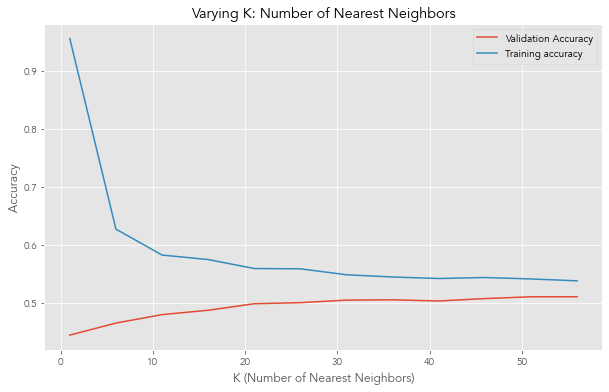

In [53]:
neighbors = np.arange(1,60,5)

# Two arrays to store training and test accuracies

train_accuracy = np.empty(len(neighbors))
validation_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    
    # Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Fit the model
    knn.fit(X_train, y_train)
    train_accuracy[i] = knn.score(X_train, y_train)
    
    scores = cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=5)
    
    validation_accuracy[i] = scores.mean()

plt.style.use('ggplot')
fig = plt.figure(figsize=(10, 6))
plt.title('Varying K: Number of Nearest Neighbors')
plt.plot(neighbors, validation_accuracy, label='Validation Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('K (Number of Nearest Neighbors)')
plt.ylabel('Accuracy')

#### Re-Run KNN with best K

In [54]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(X_train, y_train)
train_accuracy = knn.score(X_train, y_train)
print('Train Accuracy', train_accuracy)

test_accuracy_knn = knn.score(X_test, y_test)
print("\nTest Accuracy: ", test_accuracy_knn)

Train Accuracy 0.54175

Test Accuracy:  0.5015


### Build KNN

#### Build dataset for NB to predict LAW_CAT_CD

In [62]:
df_NB = df_all.head(1000000)
# df_NB = df_all[df_all['ADDR_PCT_CD'] == 103]

y=df_NB['LAW_CAT_CD']
# y=df_NB['OFNS_DESC']
X=df_NB[['ADDR_PCT_CD','DAY_OF_WEEK', 'TIME', 'TIME_CAT', 'INSIDE']]
# X=df_NB[['DAY_OF_WEEK', 'TIME', 'INSIDE']]

# X_ready = pd.get_dummies(X, columns=['ADDR_PCT_CD','DAY_OF_WEEK', 'TIME', 'TIME_CAT', 'INSIDE'])
# X_ready = pd.get_dummies(X, columns=['DAY_OF_WEEK', 'TIME', 'INSIDE'])

# le = preprocessing.LabelEncoder()
# le.fit(y)
# le.classes_
# y=le.transform(y)

enc = OrdinalEncoder()
enc.fit(X[[ 'ADDR_PCT_CD','DAY_OF_WEEK', 'TIME', 'TIME_CAT', 'INSIDE']])
X[['ADDR_PCT_CD','DAY_OF_WEEK', 'TIME', 'TIME_CAT', 'INSIDE']] = enc.transform(X[['ADDR_PCT_CD','DAY_OF_WEEK', 'TIME','TIME_CAT', 'INSIDE']])



<ipython-input-62-ad72351e7f9e>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['ADDR_PCT_CD','DAY_OF_WEEK', 'TIME', 'TIME_CAT', 'INSIDE']] = enc.transform(X[['ADDR_PCT_CD','DAY_OF_WEEK', 'TIME','TIME_CAT', 'INSIDE']])
/Users/denisgostev/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


#### Run NB to predict LAW_CAT_CD

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

classifier = GaussianNB()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

accuracy_score_test = np.mean(y_pred == y_test)
print("\nAccuracy: ", accuracy_score_test)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy:  0.57012

Test Confusion Matrix:
[[     0  60232      0]
 [     0 114024      0]
 [     0  25744      0]]


#### Build dataset for NB to 3 selected OFNS_DESC

In [66]:
ofns_list = ['BURGLARY', 'INTOXICATED & IMPAIRED DRIVING', 'PETIT LARCENY']
df_NB = df_all[df_all['OFNS_DESC'].isin(ofns_list) ]

# y=df_NB['LAW_CAT_CD']
y=df_NB['OFNS_DESC']
X=df_NB[['ADDR_PCT_CD','DAY_OF_WEEK', 'TIME', 'TIME_CAT', 'INSIDE']]
# X=df_NB[['DAY_OF_WEEK', 'TIME', 'INSIDE']]

enc = OrdinalEncoder()
enc.fit(X[[ 'ADDR_PCT_CD','DAY_OF_WEEK', 'TIME', 'TIME_CAT', 'INSIDE']])
X[['ADDR_PCT_CD','DAY_OF_WEEK', 'TIME', 'TIME_CAT', 'INSIDE']] = enc.transform(X[['ADDR_PCT_CD','DAY_OF_WEEK', 'TIME','TIME_CAT', 'INSIDE']])

<ipython-input-66-da8ad71d33ba>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['ADDR_PCT_CD','DAY_OF_WEEK', 'TIME', 'TIME_CAT', 'INSIDE']] = enc.transform(X[['ADDR_PCT_CD','DAY_OF_WEEK', 'TIME','TIME_CAT', 'INSIDE']])
/Users/denisgostev/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


#### Build data set for NB

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

classifier = GaussianNB()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

accuracy_score_test = np.mean(y_pred == y_test)
print("\nAccuracy: ", accuracy_score_test)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy:  0.7280952687066083

Test Confusion Matrix:
[[  3839   1750  41408]
 [    39  16362   2809]
 [  5072  33517 206324]]


### Build Geo grids and count crimes   

In [71]:
df_all_grd = df_all

df_all_grd=df_all_grd.head(100000)

latmin=df_all_grd['Latitude'].min() 
latmax=df_all_grd['Latitude'].max() 
latlen = latmax - latmin

lonmin=df_all_grd['Longitude'].min() 
lonmax=df_all_grd['Longitude'].max()
lonlen = lonmax - lonmin

grid_df = pd.DataFrame(columns = ["REGION_CODE", "LAT1", "LAT2", "LON1", "LON2"])

lat_n_grid = 20
lon_n_grid = 20

grid_lat_len = latlen/lat_n_grid
grid_lon_len = lonlen/lon_n_grid

region_code = 0
for i in range(lat_n_grid):
    for ix in range(lon_n_grid):
        region_code += 1
        grid_df.loc[len(grid_df.index)] = [region_code, latmin + grid_lat_len*i , latmin + grid_lat_len*(i+1),  lonmin + grid_lon_len*ix, lonmin + grid_lon_len*(ix+1)]

#assign region code to each dataframe record
def regionCode (x):
    # print('xxxxx', x[0], x[1])
    region_cd = grid_df['REGION_CODE'][(grid_df['LAT1'] <= x[0]) & (grid_df['LAT2'] >= x[0]) & (grid_df['LON1'] <= x[1]) & (grid_df['LON2'] >= x[1])]
    # region_cd = grid_df['REGION_CODE'][ (grid_df['LON1'] < x[1]) & (grid_df['LON2'] >= x[1])]
    # print('region_cd',region_cd)
    return (int(region_cd))

df_all_grd['REGION_CODE'] = df_all_grd[['Latitude','Longitude']].apply(regionCode, axis=1)

df_all_count = df_all_grd.groupby(['REGION_CODE','LAW_CAT_CD']).size().reset_index(name='counts') #per day

df_all_hot_felony = df_all_count[(df_all_count['LAW_CAT_CD'] == 'FELONY') & (df_all_count['counts'] > 200)]
df_all_hot_misd = df_all_count[(df_all_count['LAW_CAT_CD'] == 'MISDEMEANOR') & (df_all_count['counts'] > 330)]
df_all_hot_viol = df_all_count[(df_all_count['LAW_CAT_CD'] == 'VIOLATION') & (df_all_count['counts'] > 100)]

df_hot_all = pd.concat([df_all_hot_felony, df_all_hot_misd, df_all_hot_viol])

df_hot_all = pd.merge(df_hot_all, grid_df, on='REGION_CODE')

df_hot_all['CNT_LAT'] = df_hot_all['LAT1'] + (df_hot_all['LAT2'] - df_hot_all['LAT1'])/2 
df_hot_all['CNT_LON'] = df_hot_all['LON1'] + (df_hot_all['LON2'] - df_hot_all['LON1'])/2 

print(df_hot_all.head(20))
# df_test_hot_all.to_csv('df_test_hot_all.csv')

    REGION_CODE   LAW_CAT_CD  counts       LAT1       LAT2       LON1  \
0            91       FELONY     216  40.582857  40.603474 -73.977564   
1           110       FELONY     204  40.603474  40.624091 -74.005263   
2           110  MISDEMEANOR     363  40.603474  40.624091 -74.005263   
3           129       FELONY     280  40.624091  40.644707 -74.032963   
4           129  MISDEMEANOR     549  40.624091  40.644707 -74.032963   
5           129    VIOLATION     115  40.624091  40.644707 -74.032963   
6           131       FELONY     299  40.624091  40.644707 -73.977564   
7           131  MISDEMEANOR     502  40.624091  40.644707 -73.977564   
8           131    VIOLATION     108  40.624091  40.644707 -73.977564   
9           132       FELONY     309  40.624091  40.644707 -73.949864   
10          132  MISDEMEANOR     497  40.624091  40.644707 -73.949864   
11          132    VIOLATION     146  40.624091  40.644707 -73.949864   
12          133       FELONY     216  40.624091  40

<ipython-input-71-d4f6e0b8cbe0>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_grd['REGION_CODE'] = df_all_grd[['Latitude','Longitude']].apply(regionCode, axis=1)


### Build Geo census tracts and count crimes per each region

In [73]:
nynta = pd.read_csv ('/Volumes/CUNYGC/GC/CIS74020_ML/Final Project/Data/nynta.csv')

nyc_pop = pd.read_csv('/Volumes/CUNYGC/GC/CIS74020_ML/Final Project/Data/New_York_City_Population_By_Neighborhood_Tabulation_Areas.csv')
nyc_pop2010 = nyc_pop[nyc_pop['Year'] == 2010]

print(nynta.head(20))
print(nyc_pop2010.head(20))

nynta['geometry'] = nynta['the_geom'].apply(wkt.loads)
nynta_geo_df = gpd.GeoDataFrame(nynta, geometry='geometry')
nynta_geo_df.info()
nynta_geo_df['geometry']

poly = nynta_geo_df['geometry']  

df_all_cns =df_all.head(10000)

def trCode(x):
    point = Point(x['Longitude'], x['Latitude'])
    code = nynta_geo_df[poly.contains(point)]['NTACode'].item()
    return (code)
    
df_all_cns['NTACode'] = df_all_cns.apply(trCode, axis=1) 

df_all_cns_count = df_all_cns.groupby(['NTACode','LAW_CAT_CD']).size().reset_index(name='counts').sort_values(by=['counts'], ascending=False) #per day

df_all_cns_count  = pd.merge(df_all_cns_count, nyc_pop2010, left_on='NTACode', right_on='NTA Code') 

df_all_cns_count  = df_all_cns_count.merge(nyc_pop2010,left_on='NTACode',right_on='NTA Code').merge(nynta_geo_df,on='NTACode') 

print(df_all_cns_count.head(20))

#--- Add PAI Index

df_all_tot_crimes = df_all_cns.groupby(['LAW_CAT_CD']).size().reset_index(name='counts').sort_values(by=['counts'], ascending=False) #per day

# df_all_cns_count['counts']/

# df_all_tot_crimes['LAW_CAT_CD'] == df_all_tot_crimes['LAW_CAT_CD']['counts']

# df_all_tot_crimes[df_all_tot_crimes['LAW_CAT_CD'] == df_all_cns['LAW_CAT_CD']]

def paiIndex(x):
    crime_pct = x['counts']/df_all_tot_crimes[df_all_tot_crimes['LAW_CAT_CD'] == x['LAW_CAT_CD']]['counts'].item()
    area_pct = x['Shape_Area']/df_all_cns_count['Shape_Area'].sum()
    pai = crime_pct/area_pct
    # print('crime_cat', x['LAW_CAT_CD'])
    # print('total crime in cat', df_all_tot_crimes[df_all_tot_crimes['LAW_CAT_CD'] == x['LAW_CAT_CD']]['counts'].item() )
    # print('count of crime in a region', x['counts'])
    # print('crime_pct', crime_pct)
    return(pai)
    
# total_area = df_all_cns_count['Shape_Area'].sum()
df_all_cns_count['PAI'] = df_all_cns_count.apply(paiIndex, axis=1)

df_all_cns_count['PAI']

print(df_all_cns_count.groupby(['LAW_CAT_CD']).mean('PAI')['PAI'])

df_all_cns_count.groupby(['LAW_CAT_CD']).size().reset_index(name='counts').sort_values(by=['counts'], ascending=False) #per day


                                             the_geom  CountyFIPS  BoroCode  \
0   MULTIPOLYGON (((-73.97604935657381 40.63127590...          47         3   
1   MULTIPOLYGON (((-73.80379022888246 40.77561011...          81         4   
2   MULTIPOLYGON (((-73.8610972440186 40.763664477...          81         4   
3   MULTIPOLYGON (((-73.75725671443085 40.71813860...          81         4   
4   MULTIPOLYGON (((-73.95859278495766 40.61040303...          47         3   
5   MULTIPOLYGON (((-73.77757506815995 40.73019327...          81         4   
6   MULTIPOLYGON (((-73.75205066516907 40.70522802...          81         4   
7   MULTIPOLYGON (((-73.93753749374089 40.60855738...          47         3   
8   MULTIPOLYGON (((-73.97084113729679 40.64637857...          47         3   
9   MULTIPOLYGON (((-73.94826499590911 40.63860718...          47         3   
10  MULTIPOLYGON (((-73.89483522923975 40.82624684...           5         2   
11  MULTIPOLYGON (((-73.95337017508862 40.68064050..

<ipython-input-73-13eb01b3b374>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_cns['NTACode'] = df_all_cns.apply(trCode, axis=1)


   NTACode   LAW_CAT_CD  counts  Borough_x  Year_x  FIPS County Code_x  \
0     MN17  MISDEMEANOR     150  Manhattan    2010                  61   
1     MN17       FELONY      99  Manhattan    2010                  61   
2     MN17    VIOLATION      15  Manhattan    2010                  61   
3     BK82  MISDEMEANOR     117   Brooklyn    2010                  47   
4     BK82       FELONY      45   Brooklyn    2010                  47   
5     BK82    VIOLATION      23   Brooklyn    2010                  47   
6     BK61  MISDEMEANOR     111   Brooklyn    2010                  47   
7     BK61       FELONY      62   Brooklyn    2010                  47   
8     BK61    VIOLATION      25   Brooklyn    2010                  47   
9     MN34  MISDEMEANOR     105  Manhattan    2010                  61   
10    MN34       FELONY      18  Manhattan    2010                  61   
11    MN34    VIOLATION      15  Manhattan    2010                  61   
12    MN13  MISDEMEANOR      96  Manha

,LAW_CAT_CD,counts
1,MISDEMEANOR,193
0,FELONY,191
2,VIOLATION,183


#### Plot hotspots

Text(0.5, 1.0, 'VIOLATION Hotspot Cirme Map')

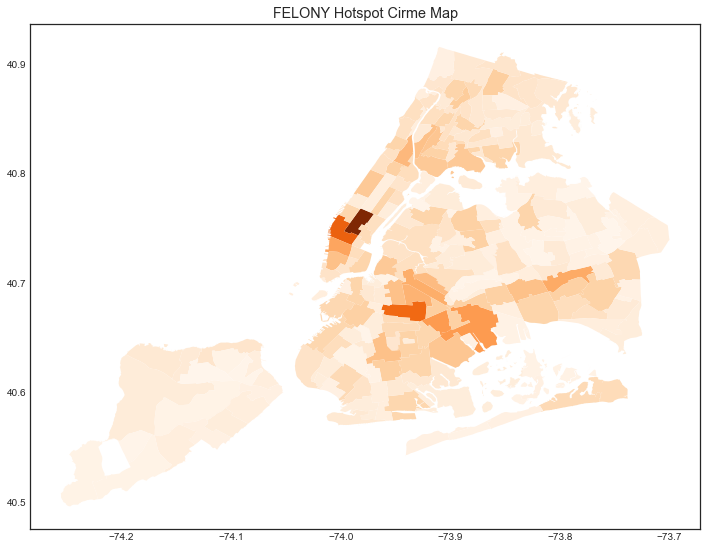

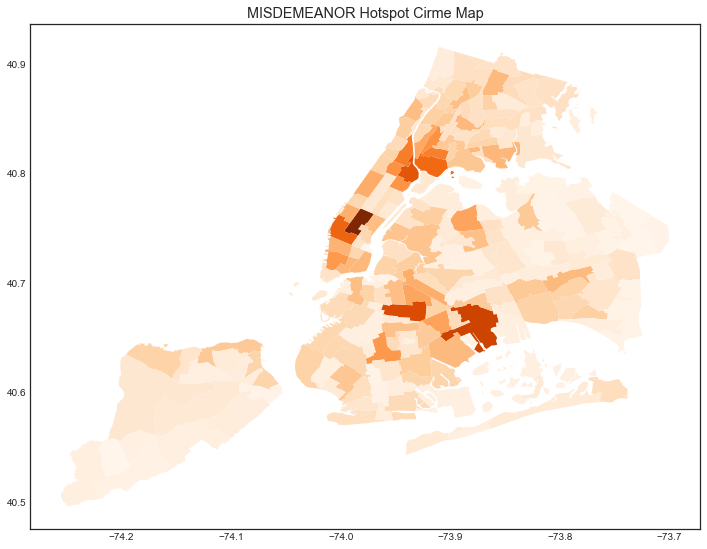

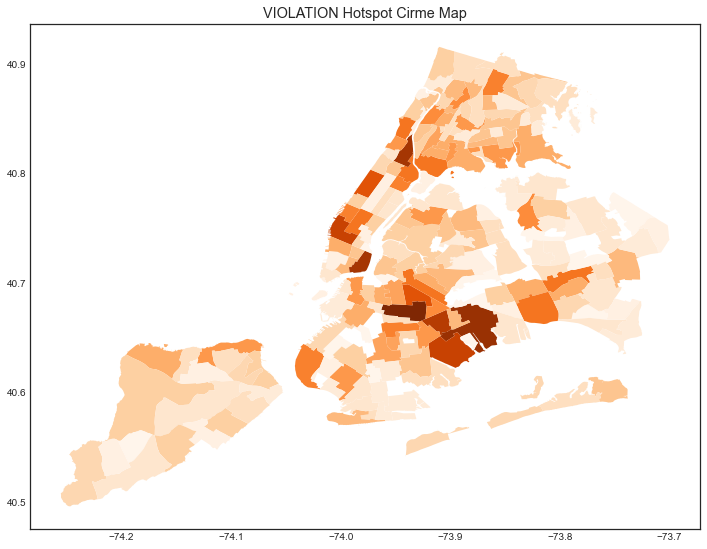

In [77]:
df_fln_count = df_all_cns_count.iloc[:,:-1][df_all_cns_count['LAW_CAT_CD'] == 'FELONY']
df_msd_count = df_all_cns_count.iloc[:,:-1][df_all_cns_count['LAW_CAT_CD'] == 'MISDEMEANOR']
df_vlt_count = df_all_cns_count.iloc[:,:-1][df_all_cns_count['LAW_CAT_CD'] == 'VIOLATION']

df_fln_pol = gpd.GeoDataFrame(df_fln_count)
df_msd_pol = gpd.GeoDataFrame(df_msd_count)
df_vlt_pol = gpd.GeoDataFrame(df_vlt_count)

plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = (12, 12)
df_fln_pol.plot(column='counts', cmap='Oranges')
plt.title('FELONY Hotspot Cirme Map')

df_msd_pol.plot(column='counts', cmap='Oranges')
plt.title('MISDEMEANOR Hotspot Cirme Map')

df_vlt_pol.plot(column='counts', cmap='Oranges')
plt.title('VIOLATION Hotspot Cirme Map')